<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [205]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [206]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x = torch.matmul(x, self.per_list[flow])

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        z = torch.matmul(z, self.per_list[flow].T)
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [207]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

train_data = Data(X_train)


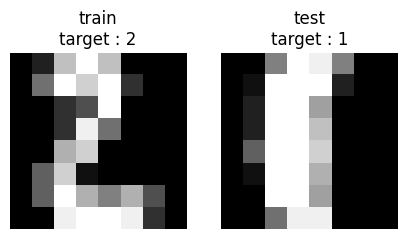

In [208]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [209]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=20)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [210]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  564.8299433390299
Epoch :  2   -----------> Loss :  91.3614616394043
Epoch :  3   -----------> Loss :  88.30110168457031
Epoch :  4   -----------> Loss :  86.13390350341797
Epoch :  5   -----------> Loss :  84.18108622233073
Epoch :  6   -----------> Loss :  82.18705368041992
Epoch :  7   -----------> Loss :  80.10671361287434
Epoch :  8   -----------> Loss :  77.94380315144856
Epoch :  9   -----------> Loss :  75.86973063151042
Epoch :  10   -----------> Loss :  73.64960861206055
Epoch :  11   -----------> Loss :  71.41054026285808
Epoch :  12   -----------> Loss :  69.15987777709961
Epoch :  13   -----------> Loss :  66.88985697428386
Epoch :  14   -----------> Loss :  64.5724500020345
Epoch :  15   -----------> Loss :  62.34317398071289
Epoch :  16   -----------> Loss :  59.95680046081543
Epoch :  17   -----------> Loss :  57.58406066894531
Epoch :  18   -----------> Loss :  55.2397206624349
Epoch :  19   -----------> Loss :  52.812933603922524
Epoc

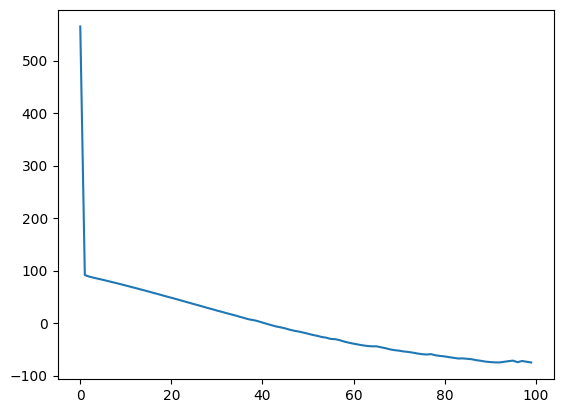

In [211]:
plt.plot(COST)

In [212]:
test = prior.sample((50,))
test

tensor([[ 0.7385, -1.0798,  0.0754,  ...,  1.3414, -0.9017,  0.4745],
        [-0.7504,  2.2465,  0.7999,  ...,  0.6897,  0.6714, -1.0798],
        [-0.3536, -1.2206,  0.6870,  ...,  0.3351, -1.7465, -0.5906],
        ...,
        [-1.3734, -2.1685, -1.0460,  ...,  1.3458, -0.7789, -0.3296],
        [-0.7592,  0.3433,  0.8491,  ...,  0.8211,  0.5064,  0.8855],
        [-2.5654, -0.1860,  0.0545,  ...,  0.8427, -0.3734,  0.5976]])

In [213]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 5.0051e-04,  2.7087e-02,  5.8197e-01,  ...,  8.6333e-01,
          3.4348e-01,  1.4127e-02],
        [-3.4382e-03,  8.6550e-02,  4.2169e-01,  ...,  1.9410e-01,
          8.3357e-02, -3.4797e-02],
        [ 2.4845e-03, -2.2817e-02,  4.6057e-01,  ...,  2.7661e-01,
         -2.3835e-01, -3.5201e-02],
        ...,
        [-6.7423e-03,  2.8615e-02,  1.6172e-01,  ...,  6.0033e-01,
         -2.4291e-01, -2.2009e-02],
        [ 4.3159e-04,  3.7416e-02,  4.1984e-01,  ...,  1.7643e-01,
          1.0013e-01,  3.1320e-02],
        [-9.6603e-03, -6.1469e-03, -3.8453e-02,  ...,  7.5163e-02,
         -1.6341e-01,  1.8039e-02]], grad_fn=<MulBackward0>)

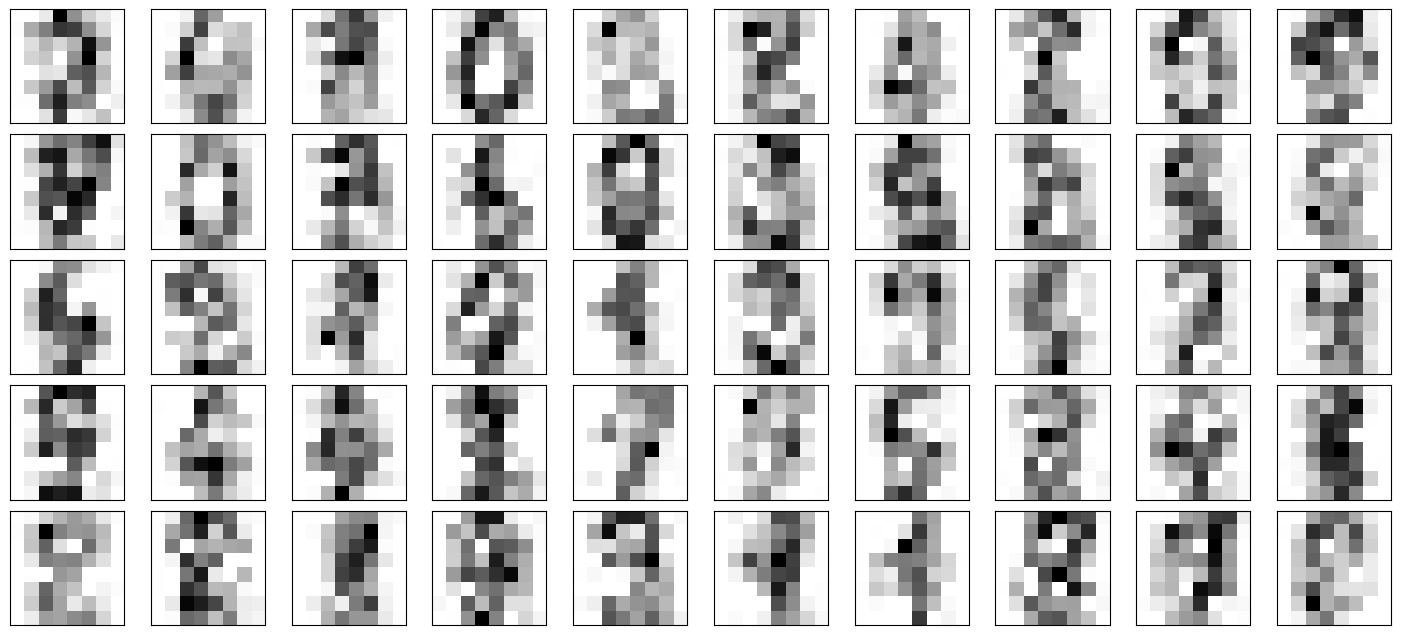

In [214]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
fig.show()


In [215]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [216]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [217]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(450, 2)


In [218]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(450, 2)


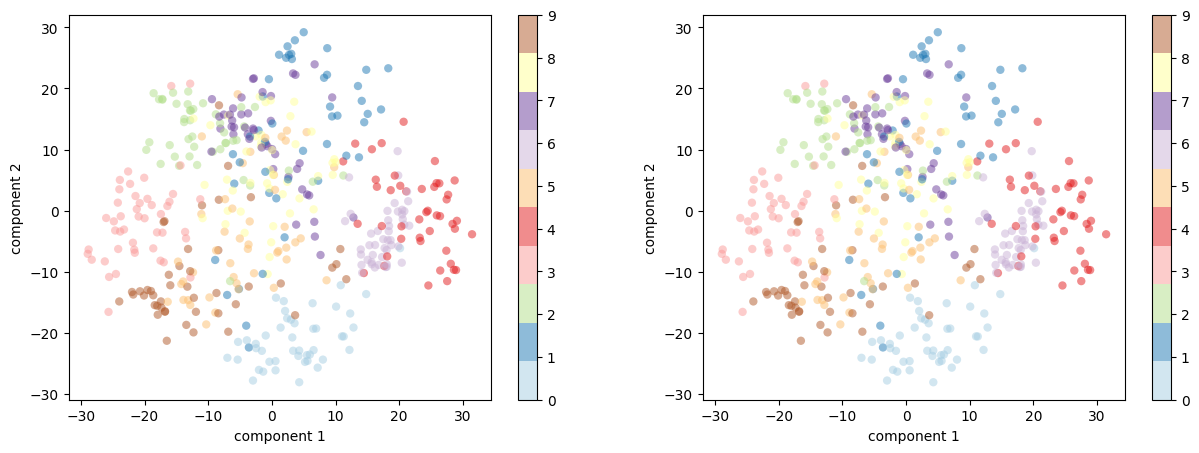

In [219]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()